In [1]:
import math

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

In [3]:
data = pd.read_csv('./extract_seoul.csv')

In [4]:
data = data.drop(['Unnamed: 0'],1)

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 30 columns):
Date               188 non-null datetime64[ns]
Total              188 non-null float64
Seoul              188 non-null float64
Northern seoul     188 non-null float64
Gangbuk-gu         188 non-null float64
Gwangjin-gu        188 non-null float64
Nowon-gu           188 non-null float64
Dobong-gu          188 non-null float64
Dongdaemun-gu      188 non-null float64
Mapo-gu            188 non-null float64
Seodaemun-gu       188 non-null float64
Seongdong-gu       188 non-null float64
Seongbuk-gu        188 non-null float64
Yongsan-gu         188 non-null float64
Eunpyeong-gu       188 non-null float64
Jongno-gu          188 non-null float64
Jung-gu            188 non-null float64
Jungnang-gu        188 non-null float64
Southern Seoul     188 non-null float64
Gangnam-gu         188 non-null float64
Gangdong-gu        188 non-null float64
Gangseo-gu         188 non-null float64
Gwanak-g

In [7]:
GU_ENG_NAME = ''

### Dict 관련 함수 선언

In [8]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [9]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [10]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### 원하는 구만 선택하기

In [11]:
def select_gu_data(df, gu_name):
    gu_name += '-gu'
    global GU_ENG_NAME
    
    GU_ENG_NAME = gu_name
    
    return df[['Date', gu_name]]
    

In [12]:
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

In [14]:
gangnam = select_gu_data(data, 'Songpa')
print(GU_ENG_NAME)

Songpa-gu


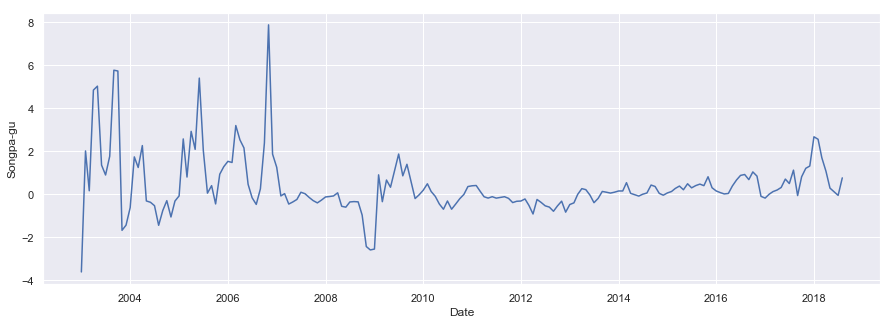

In [15]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gangnam)

### Keras import

In [16]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


In [17]:
gangnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date         188 non-null datetime64[ns]
Songpa-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [18]:
mask = pd.to_datetime('2010-01-01')
tmp = gangnam.loc[:][gangnam['Date'] >= mask]

In [19]:
gangnam_tmp = tmp.drop('Date', 1)

In [20]:
gangnam_tmp

,Songpa-gu
84,0.185549
85,0.484826
86,0.126945
87,-0.101259
88,-0.452229
89,-0.698964
90,-0.316021
91,-0.697866
92,-0.454807
93,-0.210318


### Normalize

In [21]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(gangnam_tmp)

In [22]:
dataset[:5]

array([[0.30805378],
       [0.39143499],
       [0.29172621],
       [0.22814664],
       [0.13036322]])

In [23]:
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (83, 21)


In [24]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [25]:
window_size = 4

In [26]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

whole_X, whole_Y = create_dataset(dataset, window_size)
print("Original training data shape:")
print(whole_X.shape)
print(whole_Y.shape)

Original training data shape:
(99, 4)
(99,)


In [27]:
train_Y[:10]

array([0.13036322, 0.06162063, 0.16831187, 0.0619267 , 0.1296451 ,
       0.19776183, 0.25355326, 0.35542398, 0.36534362, 0.36910647])

In [28]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

New training data shape:
(78, 1, 4)


In [29]:
MODEL_PATH = ''


if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    print("Model_path : ", MODEL_PATH)
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

In [30]:
def Model(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(12,return_sequences=True, input_shape = (1, window_size)))
    model.add(LSTM(12,return_sequences=True))
    model.add(LSTM(12))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(train_X, train_Y, epochs = 500 ,batch_size=2, validation_split = 0.1,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [31]:
model = Model(train_X, train_Y, window_size)

Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 12)             816       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 3,229
Trainable params: 3,229
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 70 samples, validate on 8 samples
Epoch 1/500
70/70 [==============================] - 2s 28ms/step - loss: 0.0585 - val_loss: 0.1496

Epoch 00001: val_loss improved from inf to 0.14963, saving model

70/70 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0126

Epoch 00037: val_loss improved from 0.01307 to 0.01263, saving model to ./TimeSeries/LSTM/Songpa-gu/val_loss-0.012626.hdf5
Epoch 38/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0118

Epoch 00038: val_loss improved from 0.01263 to 0.01177, saving model to ./TimeSeries/LSTM/Songpa-gu/val_loss-0.011767.hdf5
Epoch 39/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0105

Epoch 00039: val_loss improved from 0.01177 to 0.01050, saving model to ./TimeSeries/LSTM/Songpa-gu/val_loss-0.010503.hdf5
Epoch 40/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0103

Epoch 00040: val_loss improved from 0.01050 to 0.01035, saving model to ./TimeSeries/LSTM/Songpa-gu/val_loss-0.010350.hdf5
Epoch 41/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0097

Epoch 00041: val

70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0062

Epoch 00083: val_loss did not improve from 0.00529
Epoch 84/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0067

Epoch 00084: val_loss did not improve from 0.00529
Epoch 85/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0064

Epoch 00085: val_loss did not improve from 0.00529
Epoch 86/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0064

Epoch 00086: val_loss did not improve from 0.00529
Epoch 87/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0079

Epoch 00087: val_loss did not improve from 0.00529
Epoch 88/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0056

Epoch 00088: val_loss did not improve from 0.00529
Epoch 89/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0072



70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0061

Epoch 00136: val_loss did not improve from 0.00514
Epoch 137/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0070

Epoch 00137: val_loss did not improve from 0.00514
Epoch 138/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0056

Epoch 00138: val_loss did not improve from 0.00514
Epoch 139/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0064

Epoch 00139: val_loss did not improve from 0.00514
Epoch 140/500
70/70 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0066

Epoch 00140: val_loss did not improve from 0.00514
Epoch 141/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0091

Epoch 00141: val_loss did not improve from 0.00514
Epoch 142/500
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.

In [32]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(len(orig_data[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data)

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
rmse_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)

whole_test, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Whole data score: %.2f RMSE " % whole_test)

78
78
16
16
99
99
Training data score: 0.24 RMSE
Test data score: 0.66 RMSE
Whole data score: 0.35 RMSE 


In [35]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

498.3027241058339

In [36]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    
    ##땡기자
    print("window_size: ", window_size)
    train_predict_plot[(window_size - 1) : len(train_predict) + (window_size - 1)] = train_predict

    
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
#     test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1] = test_predict
    test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict
    
    print(test_predict_plot.shape)
    print(whole_predict.shape)

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
    plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

window_size:  4
(104, 1)
(99, 1)


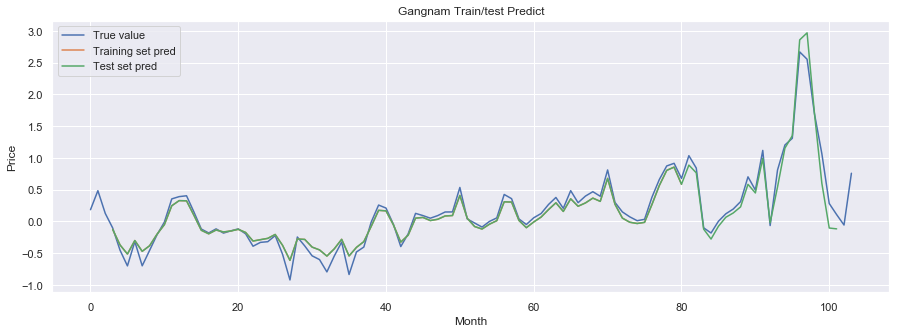

In [37]:
start_predict_n_plot(dataset, train_predict, test_predict)

In [38]:
def get_best_weights_path():
    result = MODEL_PATH +"/"+sorted(os.listdir(MODEL_PATH))[0]
    print("best model path: ", result)
    
    return result

In [39]:
best_model = get_best_weights_path()

best model path:  ./TimeSeries/LSTM/Songpa-gu/val_loss-0.005143.hdf5


In [41]:
model[0].load_weights(best_model)

In [44]:
def run_loaded_model(model, train_X, train_Y, window_size = 1):
    adam = Adam(lr=0.00146, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    history = model.fit(train_X, train_Y, epochs = 1000 ,batch_size=2, validation_split = 0.1,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [45]:
model2 = run_loaded_model(model[0], train_X, train_Y, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 12)             816       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 3,229
Trainable params: 3,229
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 70 samples, validate on 8 samples
Epoch 1/1000
70/70 [==============================] - 2s 33ms/step - loss: 0.0046 - val_loss: 0.0050

Epoch 00001: val_loss improved from inf to 0.00499, saving model to ./TimeSeries/LSTM/Songpa-gu


Epoch 00045: val_loss did not improve from 0.00365
Epoch 46/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0110

Epoch 00046: val_loss did not improve from 0.00365
Epoch 47/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0068

Epoch 00047: val_loss did not improve from 0.00365
Epoch 48/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0084

Epoch 00048: val_loss did not improve from 0.00365
Epoch 49/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0119

Epoch 00049: val_loss did not improve from 0.00365
Epoch 50/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0051

Epoch 00050: val_loss did not improve from 0.00365
Epoch 51/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0064

Epoch 00051: val_loss did not improve from 0.00365
Epoch 52/1000
70/70 [=========

70/70 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0080

Epoch 00099: val_loss did not improve from 0.00342
Epoch 100/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0103

Epoch 00100: val_loss did not improve from 0.00342
Epoch 101/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0063

Epoch 00101: val_loss did not improve from 0.00342
Epoch 102/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0101

Epoch 00102: val_loss did not improve from 0.00342
Epoch 103/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0061

Epoch 00103: val_loss did not improve from 0.00342
Epoch 104/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0055

Epoch 00104: val_loss did not improve from 0.00342
Epoch 105/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0045 - val_lo

70/70 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0053

Epoch 00152: val_loss did not improve from 0.00323
Epoch 153/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0089

Epoch 00153: val_loss did not improve from 0.00323
Epoch 154/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0041

Epoch 00154: val_loss did not improve from 0.00323
Epoch 155/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0062

Epoch 00155: val_loss did not improve from 0.00323
Epoch 156/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0055

Epoch 00156: val_loss did not improve from 0.00323
Epoch 157/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0081

Epoch 00157: val_loss did not improve from 0.00323
Epoch 158/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - val_lo

In [46]:
rmse_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)

whole_test, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Whole data score: %.2f RMSE " % whole_test)

78
78
16
16
99
99
Training data score: 0.23 RMSE
Test data score: 0.60 RMSE
Whole data score: 0.33 RMSE 


In [47]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

341.9335434667246

window_size:  4
(104, 1)
(99, 1)


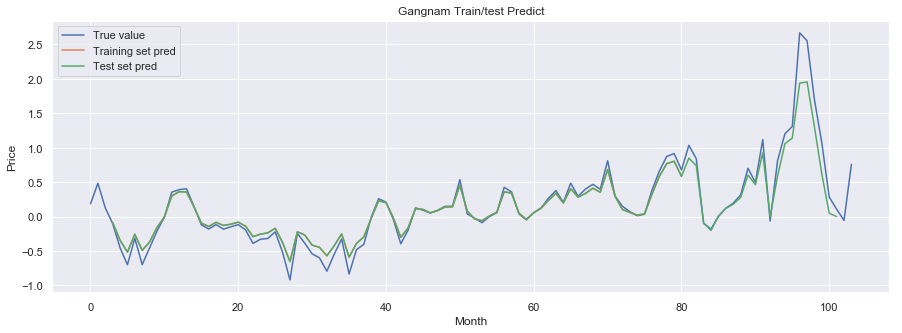

In [48]:
start_predict_n_plot(dataset, train_predict, test_predict)